<center> 
    <h3><b> Adnan Rashid </b></h3>
    <nav>
    | <a href="00-Contents-Setup.ipynb"> Home Page </a> | 
    <a href="http://bit.ly/cka_notes_original"> Kubernetes Notes </a> |
    <a href="https://adnan.study"> Website </a> |
    <a href="https://www.instagram.com/adnans_techie_studies/"> Instagram </a> |
    <a href="https://www.linkedin.com/in/adnanrashid1/"> LinkedIn </a> |
    </nav>

</center>

<center><h1 style="background:black"><code style="background:black;color:white">Stateful Containers using StatefulSets</code></h1></center>

<div class="alert alert-block alert-warning">
<font style="color:black">
<center>
    In this Chapter, we will review how to deploy MySQL database using <b>'StatefulSet'</b> and <b>'Amazon Elastic Block Store'</b> (EBS) as Persistent Volume. <br><br>

The example is MySQL single leader topology with multiple followers running asynchronous replication
 
</center></font></div>


<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/25.jpg" width="40%" height="40%" border=5/></center>

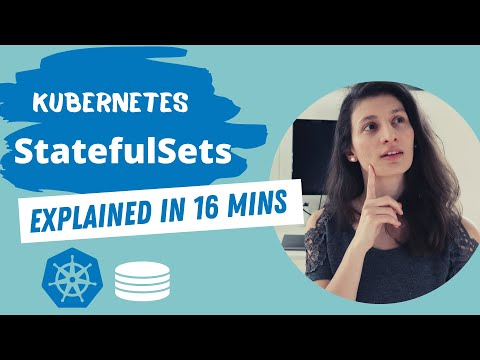

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('pPQKAR1pA9U')

<center><img src="https://www.percona.com/community-blog/wp-content/uploads/2018/10/kubernetes-mysql-operator.png" width="60%" height="60%"/

* [Amazon EBS CSI Driver](#csi)
* [Define Storageclass](#csi)
* [Create ConfigMap](#csi)
* [Create Services](#csi)
* [Create StatefulSet](#csi)
* [Test MySQL](#csi)
* [Test Failure](#csi)
* [Test Scaling](#csi)
* [Cleanup](#csi)

StatefulSet manages the deployment and scaling of a set of pods and provides guarantees about eh ordering and uniqueness of these Pods, suitable for applications that require one or more following

* Stable, unique network identifiers
* Stable, persistent storage 
* Ordered, graceful deployment and scaling 
* Ordered, automated rolling updates 


<u>More Information </u>

* StatefulSet: https://kubernetes.io/docs/concepts/workloads/controllers/statefulset/
* Persistent Volume: https://kubernetes.io/docs/concepts/storage/persistent-volumes/ 

## Pre-requisite

* Check your variables are loaded

In [ ]:
%store

* Load in variable store

In [ ]:
%store -r 

* Load variables into notebook

In [ ]:
%env AWS_PROFILE=$AWS_PROFILE
%env AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION
%env ACCOUNT_ID=$ACCOUNT_ID

* Check identity 

In [ ]:
!aws sts get-caller-identity

<br>

---
---

<br>

## <br><br>Amazon EBS Container Storage Interface (CSI) Driver 

On EKS, the open source 'EBS Container Storage Interface (CSI) driver is used to manage the attachment of Amazon EBS block storage volumes to Kubernetes Pods 
    * https://github.com/kubernetes-sigs/aws-ebs-csi-driver

#### <br><br>Configure IAM Policy 

* The CSI driver is deployed as a set of Kubernetes pods. 
* These Pods must have permission to perfrom EBS API operations, such as creating and deleting volumes, and attaching volumes to the EC2 worker nodes that comprise the cluster 


* Lets view the IAM Policy

In [ ]:
!cat ebs_csi_driver/ebs-cni-policy.json

* Create an IAM Policy from it 

In [ ]:
!aws iam create-policy --policy-name Amazon_EBS_CSI_Driver --policy-document file://ebs_csi_driver/ebs-cni-policy.json

* Get the ARN

In [ ]:
!aws iam list-policies --query 'Policies[?PolicyName==`Amazon_EBS_CSI_Driver`].Arn' --output text

* Save as variable for future reference 

In [ ]:
%env EBS_CNI_POLICY_ARN=arn:aws:iam::$ACCOUNT_ID:policy/Amazon_EBS_CSI_Driver

#### <br><br>Configure IAM Role for Service Account 

* Next, we'll ask <b>eksctl</b> to create an IAM Role that contains the IAM Policy we created and associate it with a Kubernetes Service Account called <b>'ebs-csi-controller-irsa'</b> that will be used by the CSI Driver. 

In [ ]:
%%bash

eksctl utils associate-iam-oidc-provider --cluster=eksworkshop-eksctl --approve

eksctl create iamserviceaccount --cluster eksworkshop-eksctl \
  --name ebs-csi-controller-irsa \
  --namespace kube-system \
  --attach-policy-arn $EBS_CNI_POLICY_ARN \
  --override-existing-serviceaccounts \
  --approve

#### <br><br>Deploy EBS CSI Driver 

Now we can deploy the driver and run the folder which containers a number of files 
- kustomization 
- deployment
- attacher-binding
- provisioner-binding

In [ ]:
!kubectl apply -k ebs_csi_driver

## <br><br>Define StorageClass

* Dynamic Volume Provisioning allows storage volumes to be created on-demand. 
* StorageClass should be pre-created to define which provisioner should be used and what parameters should be passed when dynamic provisioning is invoked 
<br><br>

<u> More Information </u>

* Dynamic Volume Provisioning: https://kubernetes.io/docs/concepts/storage/dynamic-provisioning/

#### <br><br>Define Storage Class 

* Here you can see the storage class is gp2  and provisioner is 'ebs'csi.aws.com'  

In [ ]:
!cat storageclass/mysql-storageclass.yml

* Create storageclass mysql-gp2

In [ ]:
!kubectl create -f storageclass/mysql-storageclass.yml 

* Verify the StorageClass and its option with this command 

In [ ]:
!kubectl describe storageclass mysql-gp2

* We will specify 'mysql-gp2' as the storageClassName in volumeClaimTemplates at 'Create StatefulSet' section later

## <br><br>Create ConfigMap

* ConfigMap allows you to decouple configuration artifacts and secrets from image content to keep containerised applications portable 
* Using ConfigMap, you can independently control MySQL configuration 

<u> More Information </u>

* ConfigMap: https://kubernetes.io/docs/concepts/configuration/configmap/

#### <br><br>Create the MySQL Namespace 

* We will create the new <b>'Namespace'</b> called <b>'mysql'</b> that will host all the components 

In [ ]:
!kubectl create namespace mysql

#### <br><br>Create ConfigMap 

* View the MySQL ConfigMap

In [ ]:
!cat storageclass/mysql-configmap.yml

* The <b>ConfigMap</b> stores master.cnf, slave.cnf and passes them when initialising leader and follower pods defined in StatefulSet. <br><br>

<b>master.cnf</b> is for the MySQL leader pod which has binary log option (log-bin) to provide a record of the data changes to be sent to the follower servers. 

<b>slave.cnf</b> is for follower pods which have super-read-only option

* Create 'mysql-config' ConfigMap 

In [ ]:
!kubectl create -f storageclass/mysql-configmap.yml

## <br><br>Create Services 

#### Introduction

Kubernetes Service defines a logical set of Pods and a policy by which to access them. 

* Service can be exposed in different ways by specifying a type in the serviceSpec. 
* StatefulSet currently requires a <b>'Headless Service'</b> to control the domain of its Pods, directly reach each Pod with stable DNS entries 
* By specifying <b>'None'</b> for the clusterIP, you can create Headless Service

<u> More Information </u>

* Kubernetes Service: https://kubernetes.io/docs/concepts/services-networking/service/
* Headless Service: https://kubernetes.io/docs/concepts/services-networking/service/#headless-services

#### <br><br>Create Services

* Check the configuration of the mysql-services.yml 

In [ ]:
!cat services/mysql-services.yml

<br><br>You can see the <b>mysql</b> service is for DNS resolution so that when pods are placed by StatefulSet controller, pods can be resolved using pod-name.mysql. <br><br>
<b>mysql-read</b> is a client service that does load balancing for all followers.

* Create mysql and mysql-read 

In [ ]:
!kubectl create -f services/mysql-services.yml 

## <br><br>Create StatefulSet

StatefulSet consists of 
<b>serviceName</b> whch is 'mysql', headless service we created in previous section <br><br>
<b>replicas</b> is 3, the desired number of pods<br><br>
<b>template</b> is the configuration of pod <br><br>
<b>volumeClaimTemplates</b> is to claim volume for pod based on storageClassName, <b>mysql-gp2</b> that we created in the 'Define StorageClass' section.


* Create the <b>StatefulSet </b> "mysql"  

In [ ]:
!kubectl create -f StatefulSet/mysql-statefulset.yml

* Watch the StatefulSet 

In [ ]:
!kubectl -n mysql rollout status statefulset mysql

* To see the progress of pods creation 

In [ ]:
!kubectl -n mysql get pods -l app=mysql 

* Check the dynamically created PVC 
* We should see STORAGECLASS 'mysql-gp2' 

In [ ]:
!kubectl -n mysql get pvc -l app=mysql 

## <br><br> Test MySQL 

You can use <b>mysql-client</b> to send some data to the leader, <b>mysql-0.mysql</b> by following command 

* Run this in terminal

* Run the following to test followers (mysql-read) received the data 

* The output will be like this

* To test load balancing across followers, run the following command.

* Output like below
* Leave this running as we test failover next 

## <br><br> Test Failure 

#### Unhealthy container 

MySQL container uses readiness probe by running mysql -h 127.0.0.1 -e 'SELECT 1' on the server to make sure MySQL server is still active. 

* Simulate MySQL as being unresponsive by running the following

In [ ]:
!kubectl -n mysql exec mysql-2 -c mysql -- mv /usr/bin/mysql /usr/bin/mysql.off

* This command renames the /usr/bin/mysql command so that readiness probe can't find it. During the next health check, the pod should report one of it's containers is not healthy. This can be verified running the followin

In [ ]:
!kubectl -n mysql get pod mysql-2

<br><br><b>mysql-read</b> load balancer detects failures and takes action by not sending traffic to the failed container, <b>@@server_id 102 </b>. 

You can check this by the loop running in the seperate window from previous section. The loop shows the following

* Revert back to its initial state at the previous terminal 

In [ ]:
!kubectl -n mysql exec mysql-2 -c mysql -- mv /usr/bin/mysql.off /usr/bin/mysql

* Check the status again to see that both containers are running and healthy

In [ ]:
!kubectl -n mysql get pod mysql-2 

<br><br>
* The loop in the terminal will now show <b> @@server_id 102 </b> is back and all three servers are running. 
* Leave the terminal open we will need it again

#### <br><br> Failed Pod 

* To simulate a failed pod, delete mysql-2 pod by following command 

In [ ]:
!kubectl -n mysql delete pod mysql-2

* StatefulSet controller recognises failed pod and creates a new one to maintain the number of replicas with the same name and link to the same <b> PersistentVolumeClaim </b> 

In [ ]:
!kubectl -n mysql get pod mysql-2

## <br><br> Test Scaling

* More followers can be added to the MySQL Cluster to increase read capacity. This can be done by following

In [ ]:
!kubectl -n mysql scale statefulset mysql --replicas=5 

* You can see the message that <b> StatefulSet </b> "mysql" scaled 

* Lets see the progress of ordered and graceful scaling 

In [ ]:
!kubectl -n mysql rollout status statefulset mysql 

<br><br>If you check the terminal again you will see 5 servers are now running

* We can verify if the newly deployed follower (mysql-3) has the same data set
* Run in a new terminal 

* output 

* Scale down replicas to 3 by following command 

In [ ]:
!kubectl -n mysql scale statefulset mysql --replicas=3 

* Check scale in is complete

In [ ]:
!kubectl -n mysql get pods -l app=mysql 

* Check <b> data-mysql-3 and data-mysql-4 </b> PVCs still exist

In [ ]:
!kubectl -n mysql get pvc -l app=mysql 

<br><br>By default, deleting a <b>PersistentVolumeClaim</b> will delete its associated persistent volume. 

What if you want to keep the volume?


* Change the reclaim policy of the <b> PersistentVolume </b> associamted with <b> PersistentVolumeClaim </b> called 'data-mysql-3' to 'Retain' 
* First find the PersistentVolume attached to the PersistentVolumeClaim <b> data-mysql-3 </b>

In [ ]:
!kubectl -n mysql  get pvc data-mysql-3 -o json | jq --raw-output '.spec.volumeName'

In [ ]:
%env pv=pvc-03d1fcdd-fb9d-4fb4-b047-bbd798d14488

* Now update the ReclaimPolicy

In [ ]:
!kubectl -n mysql patch pv ${pv} -p '{"spec":{"persistentVolumeReclaimPolicy":"Retain"}}'

* Verify the ReclaimPolicy 

In [ ]:
!kubectl get persistentVolume

<br><br>
Now, if you delete the PersistentVolumeClaim data-mysql-3, you can still see the EBS volume in the EC2 console, with its state as 'available' 

* Lets change the reclaim policy back to 'delete' to avoid orphaned volumes 

In [ ]:
!kubectl patch pv ${pv} -p '{"spec":{"persistentVolumeReclaimPolicy":"Delete"}}'

* Delete <b> data-mysql-3</b> and <b>data-mysql-4</b>

In [ ]:
!kubectl -n mysql delete pvc data-mysql-3
!kubectl -n mysql delete pvc data-mysql-4 

## <br><br> Cleanup

* Delete namespace 

In [ ]:
!kubectl delete namespace mysql

In [ ]:
!kubectl delete -f storageclass/mysql-storageclass.yml 

* Delete service account 

In [ ]:
!eksctl delete iamserviceaccount --name ebs-csi-controller-irsa --cluster=eksworkshop-eksctl --namespace kube-system

* Remove OIDC

In [ ]:
%%bash
export CLUSTER_NAME=eksworkshop-eksctl
OIDCURL=$(aws eks describe-cluster --name $CLUSTER_NAME --output json | jq -r .cluster.identity.oidc.issuer | sed -e "s*https://**")
aws iam delete-open-id-connect-provider --open-id-connect-provider-arn arn:aws:iam::$ACCOUNT_ID:oidc-provider/$OIDCURL

* Delete Policy 

In [ ]:
!aws iam delete-policy --policy-arn ${EBS_CNI_POLICY_ARN}

* EBS CNI

In [ ]:
!kubectl delete -f services/mysql-services.yml 

!kubectl delete -f storageclass/mysql-configmap.yml

!kubectl delete -f storageclass/mysql-storageclass.yml 

!kubectl delete -k ebs_csi_driver